In [1]:
import math
import torch
from torch import nn, Tensor

In [2]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的位置编码
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


In [3]:
# %% 基于位置的前馈网络
class PositionWiseFFN(nn.Module):
    """Position-wise Feed-Forward Network"""

    def __init__(self, ffn_num_input: int, ffn_num_hiddens: int, ffn_num_outputs: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X: Tensor):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.5133, -0.4115,  0.5028,  0.0954,  0.9054, -0.0140,  0.0629, -0.7706],
        [ 0.5133, -0.4115,  0.5028,  0.0954,  0.9054, -0.0140,  0.0629, -0.7706],
        [ 0.5133, -0.4115,  0.5028,  0.0954,  0.9054, -0.0140,  0.0629, -0.7706]],
       grad_fn=<SelectBackward0>)

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):
    """残差连接，followed by layer normalization"""
    def __init__(self, normalized_shape: int, dropout: float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X: Tensor, Y: Tensor) -> Tensor:
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5) # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape 

torch.Size([2, 3, 4])

In [6]:
from utils.netStructure import MultiHeadAttention


class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size: int, query_size: int, value_size: int, num_hiddens: int,
                 norm_shape: tuple, ffn_num_input: int, ffn_num_hiddens: int, num_heads: int, dropout: float,
                 use_bias: bool = False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X: Tensor, valid_lens: Tensor) -> Tensor:
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
    

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, (100, 24), 24, 48, 4, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape    

torch.Size([2, 100, 24])

In [7]:
encoder_blk

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

In [8]:
from utils.netStructure import Encoder

class TransformerEncoder(Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [9]:
from typing import List
from utils import d2l
class DecoderBlock(nn.Module):
    # The 'i'-th block in the decoder
    def __init__(self, key_size:int, query_size:int, value_size:int, num_hiddens:int, norm_shape:List[int], ffn_num_input:int, 
                 ffn_num_hiddens:int, num_heads:int, dropout:float, i:int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.i = i 
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
 
    def forward(self, X:Tensor, state:List[Tensor]) -> Tensor:
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
    
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape 

torch.Size([2, 100, 24])

In [10]:
decoder_blk

DecoderBlock(
  (attention1): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (attention2): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): Lay

In [11]:
from utils.netStructure import AttentionDecoder, PositionalEncoding


class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size:int, key_size:int, query_size:int, value_size:int, num_hiddens:int, norm_shape:List[int], ffn_num_input:int,
                 ffn_num_hiddens:int, num_heads:int, num_layers:int, dropout:float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, 
                                               ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None]*self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

# 训练
这里指定的Transformer的编码器和解码器都是<font color='orange'>2</font>层的，都使用<font color='orange'>4</font>个头的多头注意力机制。

loss 0.030, 8150.5 tokens/sed on cpu


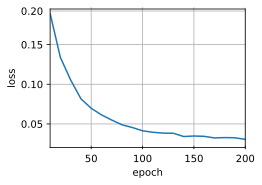

In [12]:
from sympy import im
from torch import norm

from utils.dataset import load_data_nmt
from utils.netStructure import EncoderDecoder
from utils.trainnet import train_seq2seq
from utils.gpu import try_gpu
# from utils.timer import TimerRecord

num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.004, 200, try_gpu()
print(device)
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens, 
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [13]:
encoder

TransformerEncoder(
  (embedding): Embedding(184, 32)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_features=32, out_features=32, bias=False)
        (W_v): Linear(in_features=32, out_features=32, bias=False)
        (W_o): Linear(in_features=32, out_features=32, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=32, out_features=64, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=64, out_features=32, bias=True)
      )
      (addnorm2): AddNorm(
        (dropo

In [14]:
decoder

TransformerDecoder(
  (embedding): Embedding(201, 32)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): DecoderBlock(
      (attention1): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_features=32, out_features=32, bias=False)
        (W_v): Linear(in_features=32, out_features=32, bias=False)
        (W_o): Linear(in_features=32, out_features=32, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (attention2): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_feat

In [15]:
from utils.predictor import bleu, predict_seq2seq

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [16]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

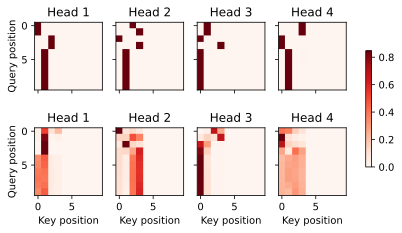

In [17]:
from utils.plot import show_heatmaps

show_heatmaps(enc_attention_weights, xlabel='Key position', ylabel='Query position', titles=['Head %d' % i for i in range(1, 5)],
              figsize=(7, 3.5))

In [18]:
import pandas as pd

dec_attention_weights_2d = [head[0].tolist() for step in dec_attention_weight_seq for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

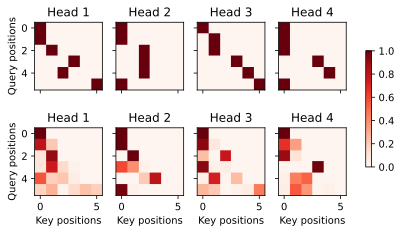

In [19]:
show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))


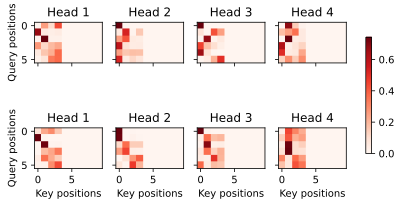

In [20]:
show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))